# PREDICTION DE LA REUSSITE SCOLAIRE

## 1. IMPORT DES LIBRAIRIES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

## 2. CHARGEMENT DES DONNÉES

In [2]:
# Load Datasets
df_mat = pd.read_csv('../sources/student/student-mat.csv', sep=';')
df_por = pd.read_csv('../sources/student/student-por.csv', sep=';')

print("Student Math shape:", df_mat.shape)
print("Student Portuguese shape:", df_por.shape)

# Display first rows
display(df_mat.head())

Student Math shape: (395, 33)
Student Portuguese shape: (649, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


## 3. EXPLORATION DES DONNÉES

In [3]:
# Check for missing values
print("Missing values in Math:", df_mat.isnull().sum().sum())
print("Missing values in Portuguese:", df_por.isnull().sum().sum())

Missing values in Math: 0
Missing values in Portuguese: 0


### Distribution of Target Variable (G3)

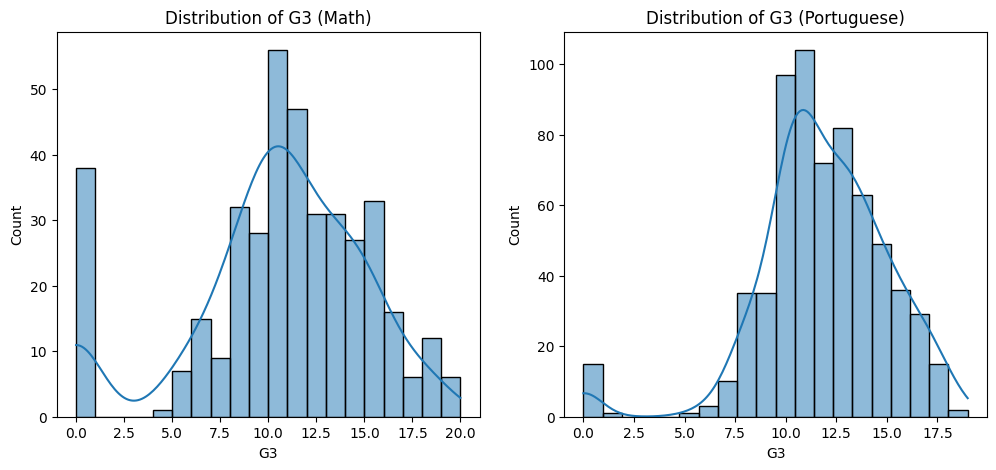

In [4]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_mat['G3'], kde=True, bins=20)
plt.title('Distribution of G3 (Math)')

plt.subplot(1, 2, 2)
sns.histplot(df_por['G3'], kde=True, bins=20)
plt.title('Distribution of G3 (Portuguese)')
plt.show()

## 4. VISUALISATIONS

### Correlation Matrix

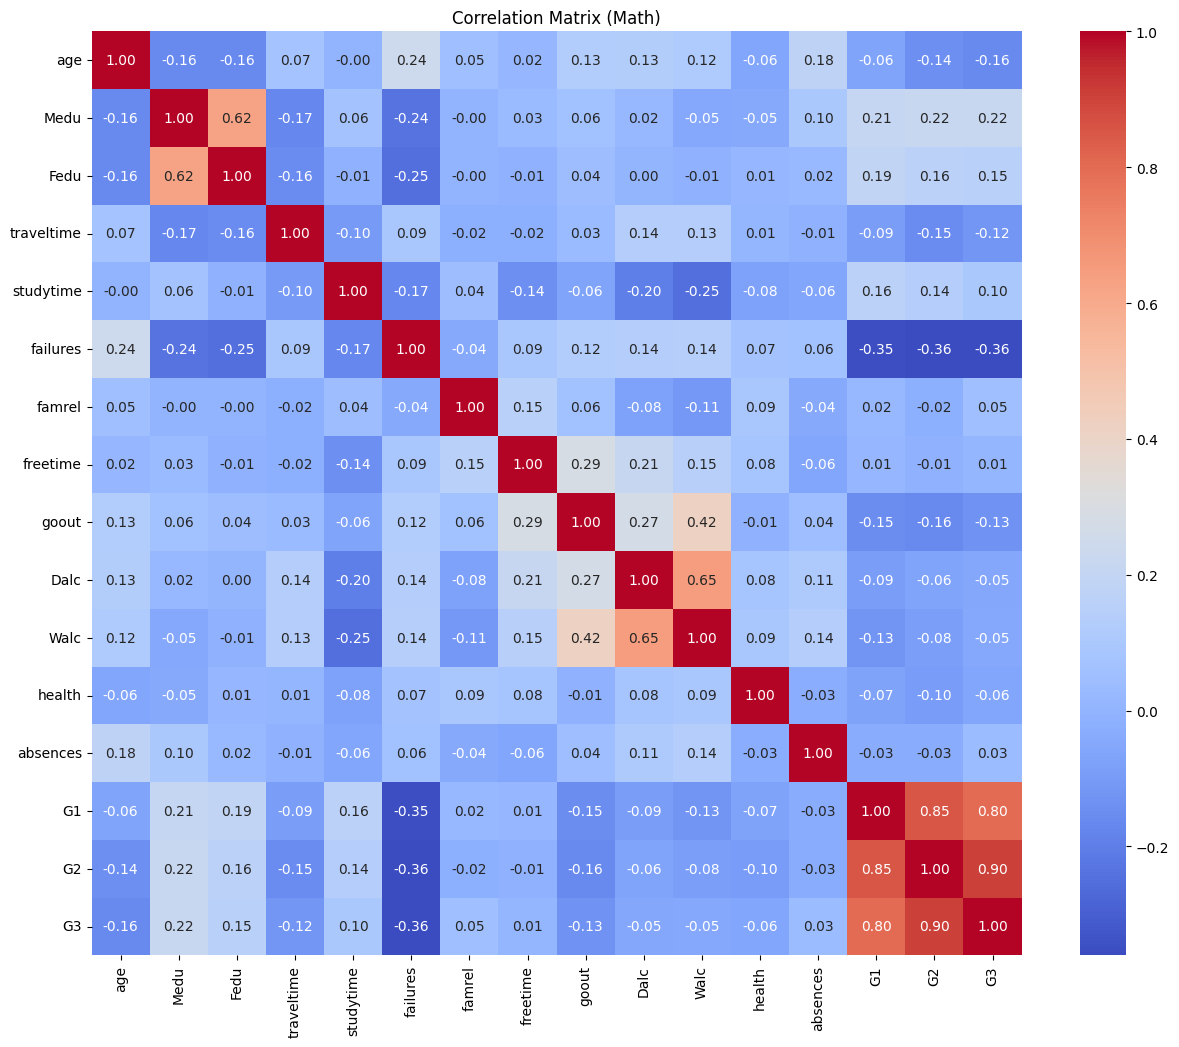

Top Correlations with G3 (Math):
G3            1.000000
G2            0.904868
G1            0.801468
Medu          0.217147
Fedu          0.152457
studytime     0.097820
famrel        0.051363
absences      0.034247
freetime      0.011307
Walc         -0.051939
Dalc         -0.054660
health       -0.061335
traveltime   -0.117142
goout        -0.132791
age          -0.161579
failures     -0.360415
Name: G3, dtype: float64


In [11]:
plt.figure(figsize=(15, 12))
sns.heatmap(df_mat.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Math)')
plt.show()

# Display top correlations with G3
print("Top Correlations with G3 (Math):")
print(df_mat.select_dtypes(include=np.number).corr()['G3'].sort_values(ascending=False))

## 5.MODÉLISATION\n
### Preprocessing

--- Scenario 1: Final Prediction (with G1, G2) ---

--- Processing Math Full ---
Used all features (including G1, G2)
Features shape: (395, 32)
Linear Regression: RMSE = 2.378, R2 = 0.724
Random Forest: RMSE = 1.958, R2 = 0.813


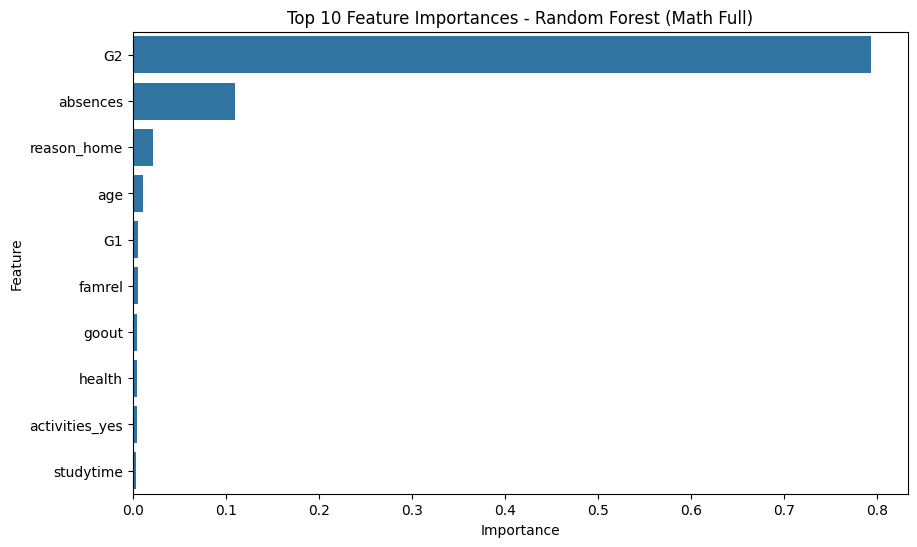


--- Processing Portuguese Full ---
Used all features (including G1, G2)
Features shape: (649, 32)
Linear Regression: RMSE = 1.215, R2 = 0.849
Random Forest: RMSE = 1.243, R2 = 0.842


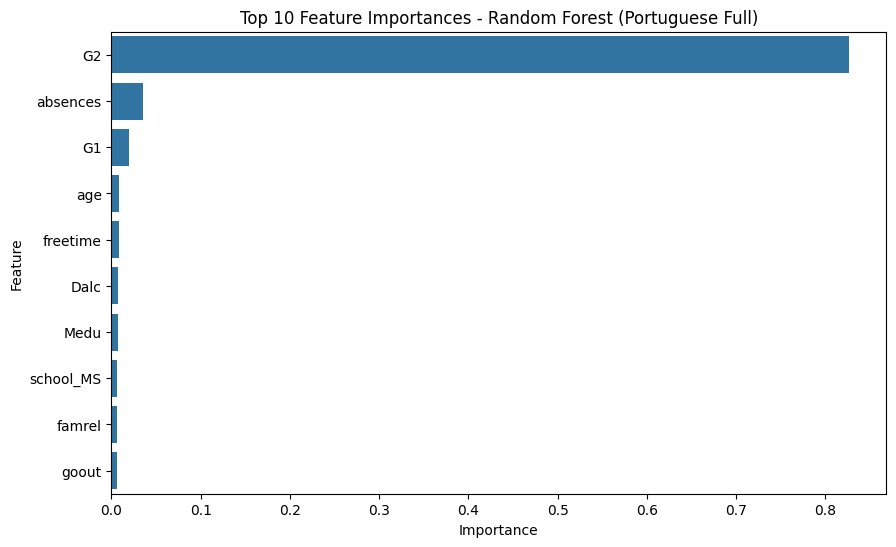


--- Scenario 2: Early Prediction (without G1, G2) ---

--- Processing Math Early ---
Dropped columns: ['G1', 'G2']
Features shape: (395, 30)
Linear Regression: RMSE = 4.196, R2 = 0.141
Random Forest: RMSE = 3.943, R2 = 0.242


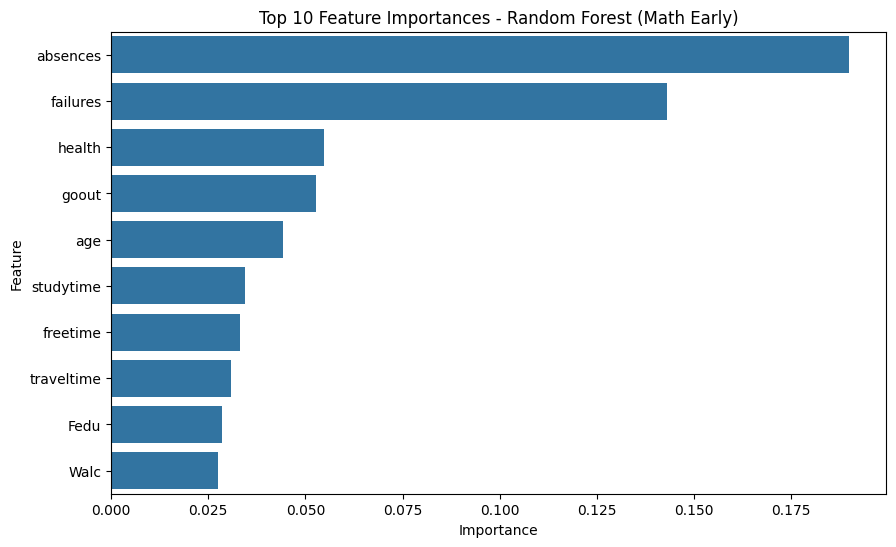


--- Processing Portuguese Early ---
Dropped columns: ['G1', 'G2']
Features shape: (649, 30)
Linear Regression: RMSE = 2.862, R2 = 0.160
Random Forest: RMSE = 2.838, R2 = 0.174


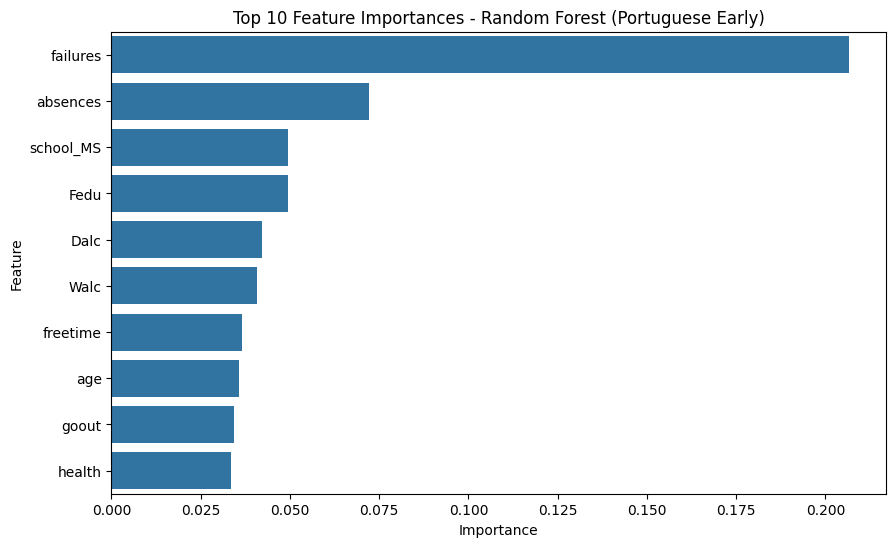

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def train_evaluate(df, subject_name, drop_cols=None):
    print(f"\n--- Processing {subject_name} ---")
    
    target = 'G3'
    if drop_cols:
        X = df.drop(drop_cols + [target], axis=1)
        print(f"Dropped columns: {drop_cols}")
    else:
        X = df.drop(target, axis=1)
        print("Used all features (including G1, G2)")
        
    y = df[target]
    
    print("Features shape:", X.shape)
    
    # Categorical and Numerical features
    cat_features = X.select_dtypes(include=['object']).columns
    num_features = X.select_dtypes(include=['int64', 'float64']).columns
    
    # Preprocessing Pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_features),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
        ])
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define Models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        # Create Pipeline
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', model)])
        
        # Train
        clf.fit(X_train, y_train)
        
        # Predict
        y_pred = clf.predict(X_test)
        
        # Evaluate
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {'RMSE': rmse, 'R2': r2, 'Model': clf}
        print(f"{name}: RMSE = {rmse:.3f}, R2 = {r2:.3f}")
        
        # Feature Importance (Random Forest)
        if name == 'Random Forest':
             # Get feature names after one-hot encoding
            ohe_feature_names = clf.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(cat_features)
            feature_names = np.r_[num_features, ohe_feature_names]
            importances = clf.named_steps['regressor'].feature_importances_
            
            # Create DataFrame for plotting
            feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
            feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(10)
            
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feat_imp)
            plt.title(f'Top 10 Feature Importances - Random Forest ({subject_name})')
            plt.show()
    
    return results

print("--- Scenario 1: Final Prediction (with G1, G2) ---")
# Run for Math
results_mat_full = train_evaluate(df_mat, "Math Full")

# Run for Portuguese
results_por_full = train_evaluate(df_por, "Portuguese Full")

print("\n--- Scenario 2: Early Prediction (without G1, G2) ---")

# Run for Math
results_mat_early = train_evaluate(df_mat, "Math Early", drop_cols=['G1', 'G2'])

# Run for Portuguese
results_por_early = train_evaluate(df_por, "Portuguese Early", drop_cols=['G1', 'G2'])

## 6. DATASET MERGING & COMPARISON

Number of students in both courses: 382

Correlation between G3 Math and G3 Portuguese:
          G3_mat    G3_por
G3_mat  1.000000  0.480349
G3_por  0.480349  1.000000


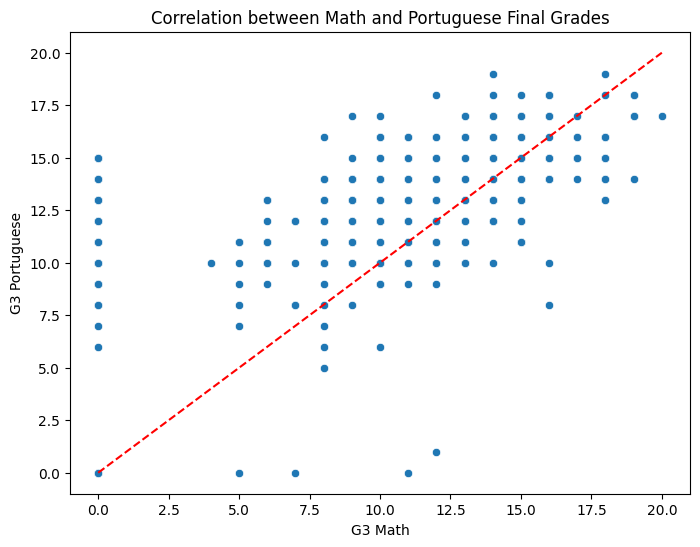

In [7]:
# Merge datasets based on student attributes
merge_cols = ["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"]
df_merge = pd.merge(df_mat, df_por, on=merge_cols, suffixes=('_mat', '_por'))

print(f"Number of students in both courses: {df_merge.shape[0]}")

# Correlation between Math and Portuguese grades
grade_corr = df_merge[['G3_mat', 'G3_por']].corr()
print("\nCorrelation between G3 Math and G3 Portuguese:")
print(grade_corr)

plt.figure(figsize=(8, 6))
sns.scatterplot(x='G3_mat', y='G3_por', data=df_merge)
plt.title('Correlation between Math and Portuguese Final Grades')
plt.xlabel('G3 Math')
plt.ylabel('G3 Portuguese')
plt.plot([0, 20], [0, 20], 'r--') # Reference line y=x
plt.show()

## 7. FEATURE ENGINEERING

New Features Created: TotalAlc, ParentEdu, HasFailed

--- Re-evaluating Early Prediction with Feature Engineering ---

--- Processing Math FE ---
Dropped columns: ['G1', 'G2']
Features shape: (395, 33)
Linear Regression: RMSE = 4.127, R2 = 0.169
Random Forest: RMSE = 3.899, R2 = 0.259


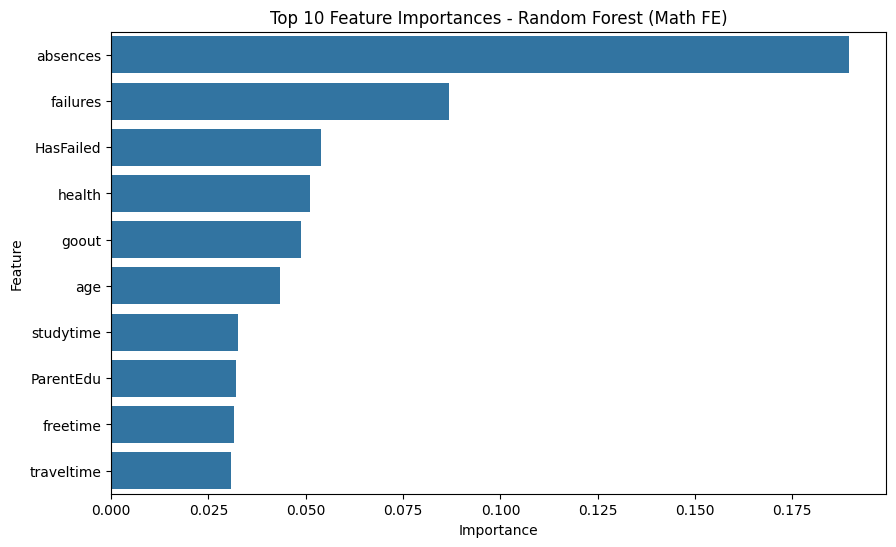


--- Processing Portuguese FE ---
Dropped columns: ['G1', 'G2']
Features shape: (649, 33)
Linear Regression: RMSE = 2.824, R2 = 0.182
Random Forest: RMSE = 2.893, R2 = 0.142


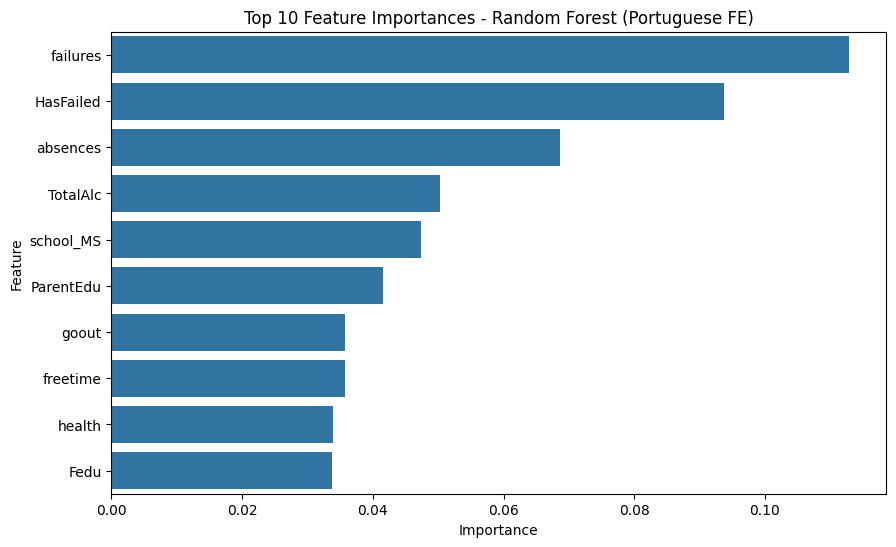

In [8]:
def create_features(df):
    df = df.copy()
    # Total Alcohol Consumption
    df['TotalAlc'] = df['Dalc'] + df['Walc']
    
    # Parental Education Score
    df['ParentEdu'] = df['Medu'] + df['Fedu']
    
    # Failed at least once
    df['HasFailed'] = df['failures'].apply(lambda x: 1 if x > 0 else 0)
    
    # Study Time is already ordinal 1-4, maybe keep as is or bin if needed.
    return df

# Apply to datasets
df_mat_fe = create_features(df_mat)
df_por_fe = create_features(df_por)

print("New Features Created: TotalAlc, ParentEdu, HasFailed")

print("\n--- Re-evaluating Early Prediction with Feature Engineering ---")
# Run for Math
results_mat_fe = train_evaluate(df_mat_fe, "Math FE", drop_cols=['G1', 'G2'])

# Run for Portuguese
results_por_fe = train_evaluate(df_por_fe, "Portuguese FE", drop_cols=['G1', 'G2'])

## 8. SCENARIO 3: MERGED DATASET

In [10]:
print("\n--- Scenario 3: Merged Dataset Integration (Early Prediction) ---
# Stack datasets (Concatenation, not Merge by student)
# We treat them as independent samples but add a 'Subject' attribute
df_mat_fe['Subject'] = 0 # 0 for Math
df_por_fe['Subject'] = 1 # 1 for Portuguese

df_combined = pd.concat([df_mat_fe, df_por_fe], axis=0).reset_index(drop=True)

print(f"Combined Dataset Shape: {df_combined.shape}")

# Train on Combined Dataset
results_combined = train_evaluate(df_combined, "Combined Math+Por", drop_cols=['G1', 'G2'])

SyntaxError: unterminated string literal (detected at line 1) (1988565075.py, line 1)

## 9. CONCLUSION & RECOMMANDATIONS\n
### Synthèse des Résultats\n
1. **Scénario 'Prédiction Finale' (Late, avec notes)**: R2 > 0.8. Excellent modèle pour affiner la note.\n
2. **Scénario 'Prédiction Précoce' (Early, sans notes)**: R2 ~ 0.25 (Math), ~ 0.14 (Por). Prédiction difficile.\n
\n
### Recommandations\n
- **Usage**: Utiliser le modèle 'Early' pour de la **détection**, pas de la prédiction fine.\n
- **Données**: Collecter plus d'historique (notes trimestres précédents même d'autres années) améliorerait la prédiction précoce.